In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# The Data
[Read about the data here](https://www.kaggle.com/lava18/google-play-store-apps)

In [45]:
df = pd.read_csv("data/google-play-store-apps/googleplaystore.csv")
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [46]:
google_play_reviews_df = pd.read_csv("data/google-play-store-apps/googleplaystore_user_reviews.csv")
google_play_reviews_df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


# Question 1: 
Which app category, in your opinion, has the best ratings? How are you measuring best ratings?


Use the `googleplaystore.csv`

The category with the best ratings is the category with the highest average rating. 

To begin with, we explore what categories there are. I chose to drop the category '1.9', as it had only one value and didn't seem obviously a part of another category. This exploration also revealed that there were some null values for rating, but I chose to deal with those at a later point.

In [137]:
df.info()
df['Category'].unique()
df = df.drop(df.loc[df['Category'] == '1.9'].index)
df['Category'] = df['Category'].apply(lambda x : x.replace('_', ' ').strip().title()) # a small beautification

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10840
Data columns (total 13 columns):
App               10840 non-null object
Category          10840 non-null object
Rating            9366 non-null float64
Reviews           10840 non-null object
Size              10840 non-null object
Installs          10840 non-null int32
Type              10839 non-null object
Price             10840 non-null object
Content Rating    10840 non-null object
Genres            10840 non-null object
Last Updated      10840 non-null object
Current Ver       10832 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), int32(1), object(11)
memory usage: 1.1+ MB


Next, we separate the dataframe into subsets for each category.

In [48]:
cat_dict = {}
for cat in df['Category'].unique():
    cat_dict[cat] = df.loc[df['Category'] == cat]

At this point, we can check the number of null values per category. Doing this here lets us easily see whether null values are spread evenly or concentrated in one category. The following code tells us the percentage of null values per category.

In [49]:
for k in cat_dict.keys():
    print(k, cat_dict[k]['Rating'].isna().sum() / len(cat_dict[k]))

Art And Design 0.046153846153846156
Auto And Vehicles 0.1411764705882353
Beauty 0.20754716981132076
Books And Reference 0.22943722943722944
Business 0.34130434782608693
Comics 0.03333333333333333
Communication 0.1524547803617571
Dating 0.16666666666666666
Education 0.00641025641025641
Entertainment 0.0
Events 0.296875
Finance 0.11748633879781421
Food And Drink 0.14173228346456693
Health And Fitness 0.12903225806451613
House And Home 0.13636363636363635
Libraries And Demo 0.23529411764705882
Lifestyle 0.17801047120418848
Game 0.04108391608391608
Family 0.1140973630831643
Medical 0.24406047516198703
Social 0.12203389830508475
Shopping 0.08461538461538462
Photography 0.05373134328358209
Sports 0.16927083333333334
Travel And Local 0.12403100775193798
Tools 0.12930011862396204
Personalization 0.1989795918367347
Productivity 0.1721698113207547
Parenting 0.16666666666666666
Weather 0.08536585365853659
Video Players 0.08571428571428572
News And Magazines 0.17667844522968199
Maps And Navigation

Since in some cases the null value proportion is as much as 34%, it does not make sense to simply drop all null values. Instead, since we are concerned with averages for each category, we will impute the median for each category. This should have the least effect on the mean.

In [27]:
for v in cat_dict.values():
    v = v['Rating'].fillna(v['Rating'].median(), inplace = True)

Having dealt with null values, we can proceed to find the best ratings. The most naive way to do this would be to simply average the rating of apps for each category, as follows:

In [51]:
category_ratings = {}
for k in cat_dict.keys():
    category_ratings[k] = cat_dict[k]['Rating'].mean()

The issue with this approach is that it ignores the number of ratings per app. For example, if an app has 1000 ratings and an average rating of 4 stars, this should have more weight in the category's overall ratings than another app with only 1 rating of 5 stars. As it stands, our system would take these two and say the category has an average rating of 4.5; this would not be accurate. In other words, the system above finds the average rating of apps per category, but not the average rating per category itself.

So we need to weigh the quantity of ratings in our calculations. This we can do by multiplying an app's total rating by the number of ratings it has. We then average this new number to find the average rating given to the category's apps.

In [52]:
# first, it is necessary to change the Reviews column to an integer so that we can work with it
cat_ratings_weighted = {}

for k in cat_dict.keys():
    # first, it is necessary to change the Reviews column to an integer so that we can work with it
    cat_dict[k]['Reviews'] = cat_dict[k]['Reviews'].astype('float')
    # here we find the total stars of all reviews in a category
    cat_dict[k]['Weighted Reviews'] = cat_dict[k]['Reviews'] * cat_dict[k]['Rating']
    # here we find the average of reviews by dividing by the sum of reviews
    cat_ratings_weighted[k] = cat_dict[k]['Weighted Reviews'].sum() / cat_dict[k]['Reviews'].sum()

C:\Users\kcali\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\kcali\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


We now have a dictionary containing the names of the categories as well as the average rating per category. It is from here a simple matter to plot them out.

Text(0, 0.5, 'Rating')

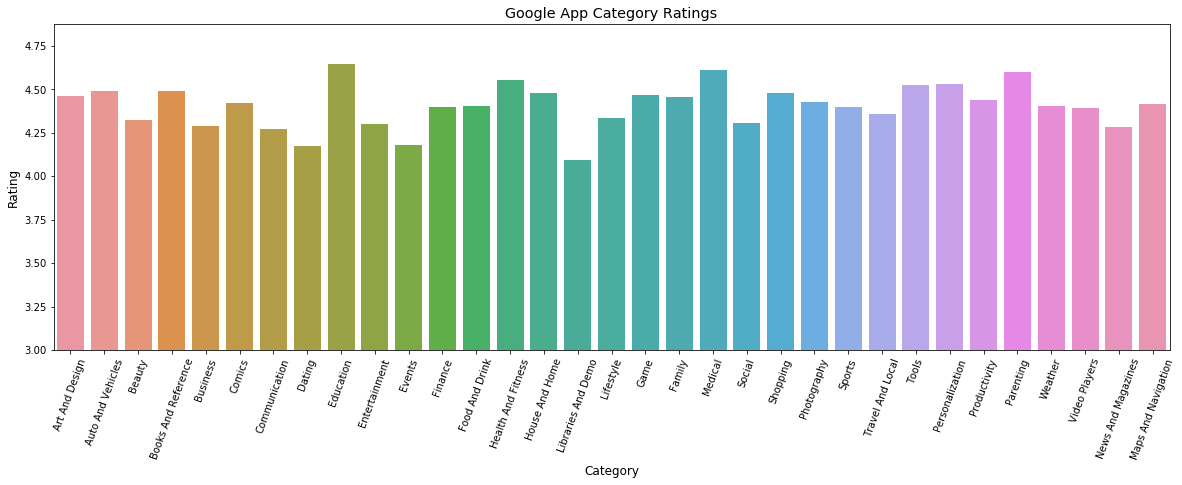

In [85]:
# fig = plt.figure(figsize=(20, 10))
# ax = fig.add_subplot(111)
# plt.bar(cat_ratings_weighted.keys(), cat_ratings_weighted.values(), color='purple', linewidth='0.1')
# plt.xticks(rotation='45')
# ax.set_title('Google Play Store App Category Ratings', fontsize='xx-large')
# ax.set_xlabel('App Category', fontsize='x-large')
# ax.set_ylabel('Rating', fontsize='x-large')
# ax.set_ylim(bottom = 3)
plt.figure(figsize=(20, 6))
sns.barplot(x=list(cat_ratings_weighted.keys()), y=list(cat_ratings_weighted.values()))
plt.xticks(rotation=70)
plt.ylim(3)
plt.title('Google App Category Ratings', fontsize='x-large')
plt.xlabel('Category', fontsize='large')
plt.ylabel('Rating', fontsize='large')
